# Exploring CLIP

This notebook is based on--and the first third of it is almost identical to--"Interacting with CLIP.ipynb." I'm not sure who authored that notebook, but it is very similar to code snippets provided by OpenAI [in their documentation of the CLIP model.](https://github.com/openai/CLIP)

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-181uqv34
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-181uqv34


In [ ]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.9.0+cu111


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [ ]:
import clip

clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [ ]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7efbe76b8830>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [18]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

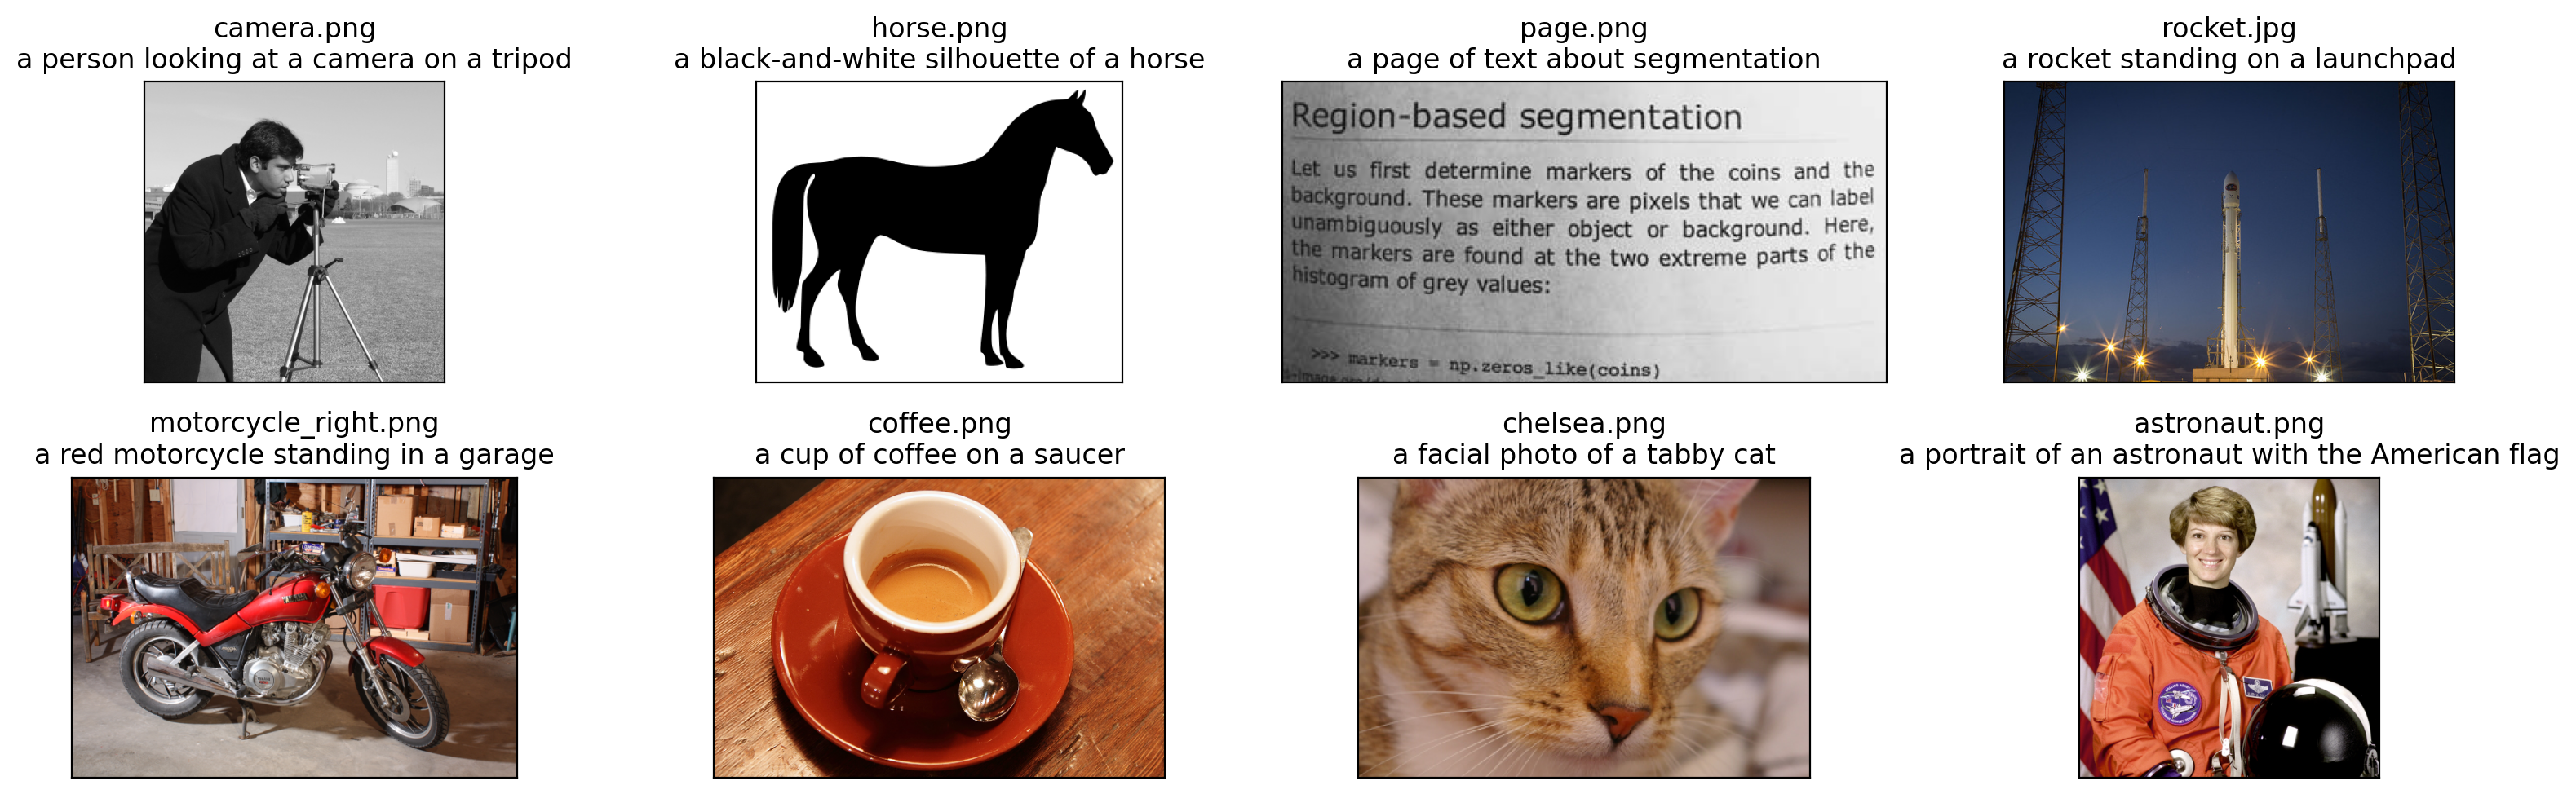

In [20]:
skimage.data.download_all(directory=None)
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue
    else:
        image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()



## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

A few notes here. Functions like ```.cuda()``` and ```.cpu()``` are being used to put these matrices into a format where they can run on a Graphics Processing Unit (GPU), and then back into the normal format we expect in Python, which runs on a CPU.

The at-sign operator computes the dot product of two matrices, and the ```.T``` transposes a matrix.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# First experiment

That diagonal line seems very neat and good. But how fragile is CLIP?

Are there plausible ways you could describe these images that *wouldn't* work as well? Go back to the cell where the images were associated with descriptions and see if you can make up alternate descriptions of these pictures that are just as accurate but don't use exactly the same terms or details.

When you use those descriptions for the cosine similarity matrix, how well does the diagonal hold up?

# Zero-Shot Image Classification

The strategy adopted here is to load a dataset with 100 categories and turn the category names into description strings on the pattern "This is a photo of a {label}." Then we use those strings to categorize the eight images from the experiment above.

Since the categories in CIFAR100 are not guaranteed to line up with the photos above, this approach may not always generate a good match! But it's a fair model of the results you might get if you tried to sort random images into a set of predefined categories.

In [15]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169M/169M [00:03<00:00, 45.7MB/s]


In [16]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

**Turning cosine similarity into class probabilities:**

The math that follows is slightly interesting. We calculate cosine similarities for all the classes, as we did before.

But then we turn those numbers into probabilities using a *softmax* function. Essentially this replaces all the elements k1, k2, k3 of a vector with $e^{k1}, e^{k2}$ etc, and then normalizes the whole vector by dividing by sum(vector). This guarantees that all the class probabilities will add up to 1.

In [17]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

NameError: name 'image_features' is not defined

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

Hmm. confusing a cat with a sweet pepper, and text with a bed.

# What if we tried to categorize CIFAR images using the CIFAR labels?

Not surprisingly, this performs a little better.

The CIFAR images have been loaded as ordinary numpy arrays, but the "preprocess" function that crops them and sizes them appropriately for CLIP expects PIL "Image" objects, so we convert them into "Images" before preprocessing.


In [ ]:
image_input = torch.tensor(np.stack([preprocess(Image.fromarray(x)) for x in cifar100.data[0:8]])).cuda()


To generate textual descriptions of the images, we rely on the fact that cifar100 has a list of "targets" (integers that indicate the class of the corresponding image). These can be converted into text using the list of classes that is also in cifar100.

In [ ]:
print('Classes in order:', cifar100.classes[0:10])
print('Indices for the first eight pictures:', cifar100.targets[0:8])

text_tokens = clip.tokenize([f"This is a photo of a {cifar100.classes[label]}" for label in cifar100.targets[0:8]]).cuda()

Classes in order: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
Indices for the first eight pictures: [19, 29, 0, 11, 1, 86, 90, 28]


The next part is entirely unchanged from above. We simply run the model to turn images and texts into vectors.

Then we compute cosine similarity by normalizing the vectors and taking their dot products.

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
similarity

array([[0.27343854, 0.24354905, 0.23996335, 0.2025621 , 0.22570327,
        0.21436776, 0.19859333, 0.22116135],
       [0.2089665 , 0.29010996, 0.23967582, 0.21089977, 0.23766577,
        0.22087982, 0.2154713 , 0.23020539],
       [0.21389535, 0.20332944, 0.29501495, 0.20362425, 0.21367376,
        0.22876751, 0.20162067, 0.22173738],
       [0.21677355, 0.21824512, 0.22865984, 0.25673196, 0.21470883,
        0.22683457, 0.21595462, 0.21645576],
       [0.17041393, 0.21067548, 0.21061905, 0.1883725 , 0.22482362,
        0.21281083, 0.18068421, 0.20662072],
       [0.21078748, 0.20027304, 0.2442557 , 0.21207994, 0.21074262,
        0.2335949 , 0.20300429, 0.22756481],
       [0.20857102, 0.19612856, 0.22175726, 0.1906318 , 0.20371807,
        0.21951902, 0.28274018, 0.19507961],
       [0.20238864, 0.1909101 , 0.22442599, 0.1876276 , 0.19815707,
        0.22920305, 0.18979333, 0.30402297]], dtype=float32)

This is largely unchanged from above, except that I've substituted cifar_descriptions and cifar images.

In [ ]:
count = 8
cifar_descriptions = [cifar100.classes[x] for x in cifar100.targets[0:8]]

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), cifar_descriptions, fontsize=18)
plt.xticks([])
for i, image in enumerate(cifar100.data[0:8]):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

### Glance forward at homework

The section we just worked through will come back in Homework 7, due October 31. I'll ask you to use CLIP to classify several hundred images from CIFAR100, and then assess the accuracy of the model.

If you wanted to save this to your Google Drive you could uncomment the lines below.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Second experiment, with movie posters

Let's see whether CLIP can recognize the cultural meaning in complex images: movie posters.

Your first mission here is to flesh out the code for measuring cosine similarity (using the models above).

Then, after you've measured the similarity of the movie posters to the seven descriptions I provide, I'll ask you to confer in small groups. Change aspects of the experiment so you can better understand why CLIP succeeds (where it succeeds) and why it fails when it fails. In particular, the posters for Carol, Love Story, and Text Matrix create interesting puzzles.

To run this section you'll need to upload ```posters.zip,``` by clicking the icon like a page with an up arrow on the far left. Then you can unzip it by running the cell below.

In [ ]:
!unzip posters.zip

Archive:  posters.zip
   creating: posters/
  inflating: posters/Star_Wars.jpg   
  inflating: __MACOSX/posters/._Star_Wars.jpg  
  inflating: posters/.DS_Store       
  inflating: __MACOSX/posters/._.DS_Store  
  inflating: posters/Lose_A_Guy.jpg  
  inflating: __MACOSX/posters/._Lose_A_Guy.jpg  
  inflating: posters/Carol.jpg       
  inflating: __MACOSX/posters/._Carol.jpg  
  inflating: posters/Titanic.jpg     
  inflating: __MACOSX/posters/._Titanic.jpg  
  inflating: posters/The_Matrix.jpg  
  inflating: __MACOSX/posters/._The_Matrix.jpg  
  inflating: posters/Text_Matrix.jpg  
  inflating: __MACOSX/posters/._Text_Matrix.jpg  
  inflating: posters/Love_Story.jpg  
  inflating: __MACOSX/posters/._Love_Story.jpg  
  inflating: posters/Die_Hard.jpg    
  inflating: __MACOSX/posters/._Die_Hard.jpg  
  inflating: posters/Love_Story_2050.jpg  
  inflating: __MACOSX/posters/._Love_Story_2050.jpg  


In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir('posters/') if filename.endswith(".jpg") and 'Text' not in filename]:
    # There are nine files in the folder and it's hard to display more than eight, so I've excluded one
    # with a "not in" condition. Later we can change which one is excluded by replacing 'Text' with
    # '2050'.

    image = Image.open(os.path.join('posters/', filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(filename.replace('.jpg', ''))

plt.tight_layout()

In [ ]:
img_descriptions = ['a poster for an action movie',
                    'a poster for a romance movie',
                    'a poster for a bengali movie',
                    'a poster for star wars',
                    'a poster for the matrix',
                    'a poster for a science fiction movie',
                    'a love story']

In [ ]:
image_input = ?    # what would you need to put here?
text_tokens = ?    # and here?

In [ ]:
# what happens now?

In [ ]:
# and now?

In [ ]:
# and finally, how do you visualize the results as a similarity matrix?

# Third experiment

Create your own folder of 4-5 images (perhaps works of art from different periods or regions?) Zip it and upload it.

Then write your own text strings to see if CLIP can distinguish regions or periods from each other.